In [82]:
import numpy as np
import utils 
import matplotlib.pyplot as plt
from matplotlib.pylab import subplots
import importlib

importlib.reload(utils)

filename = "./data/0020.npz"
t,features,linear_velocity,rotational_velocity,K,b,cam_T_imu = utils.load_data(filename)

In [21]:
# Add noise to linear and rotational velocity

linear_velocity += np.random.normal(0,0.0025)
rotational_velocity += np.random.normal(0,0.0025)

In [83]:
print("Shape of t: {}".format(t.shape))
print("Shape of features: {}".format(features.shape))
print("Shape of linear_velocity: {}".format(linear_velocity.shape))
print("Shape of rotational_velocity: {}".format(rotational_velocity.shape))
print("Shape of K: {}".format(K.shape))
print("Shape of b: {}".format(b.shape))
print("Shape of cam_T_imu: {}".format(cam_T_imu.shape))

Shape of t: (1, 1104)
Shape of features: (4, 260, 1104)
Shape of linear_velocity: (3, 1104)
Shape of rotational_velocity: (3, 1104)
Shape of K: (3, 3)
Shape of b: ()
Shape of cam_T_imu: (4, 4)


In [84]:
print(K)
print(b)
print(cam_T_imu)
tau = t[0,1] - t[0,0]
print(tau)

[[707.0912   0.     601.8873]
 [  0.     707.0912 183.1104]
 [  0.       0.       1.    ]]
0.5371506532679237
[[-1.08863514e-03 -9.99976347e-01  6.78718180e-03  1.14389871e+00]
 [-8.51207214e-03 -6.77767115e-03 -9.99940872e-01 -3.12718471e-01]
 [ 9.99963177e-01 -1.14634293e-03 -8.50449310e-03  7.26546045e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0.10450553894042969


In [85]:
# Construct M

M = np.array([[ K[0,0], 0, K[0,2], 0 ],
             [ 0, K[1,1], K[1,2], 0 ],
             [ K[0,0], 0, K[0,2], -b*K[0,0] ],
             [ 0, K[1,1], K[1,2], 0 ]])
print(M)

[[ 707.0912    0.      601.8873    0.    ]
 [   0.      707.0912  183.1104    0.    ]
 [ 707.0912    0.      601.8873 -379.8145]
 [   0.      707.0912  183.1104    0.    ]]


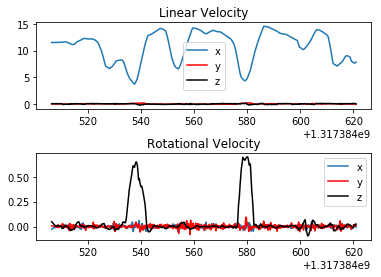

In [86]:
plt.subplot(2,1,1)
plt.plot(t[0,:], linear_velocity[0,:], label='x' )
plt.plot(t[0,:], linear_velocity[1,:], 'r', label='y' )
plt.plot(t[0,:], linear_velocity[2,:], 'k', label='z' )
plt.legend()
plt.title('Linear Velocity')

plt.subplot(2,1,2)
plt.plot(t[0,:], rotational_velocity[0,:], label='x' )
plt.plot(t[0,:], rotational_velocity[1,:], 'r', label='y' )
plt.plot(t[0,:], rotational_velocity[2,:], 'k', label='z' )
plt.legend()
plt.title('Rotational Velocity')

plt.subplots_adjust(hspace=0.5)
plt.show()

## Part A

In [87]:
def predict_EKF(current_pose, lin_velocity, ang_velocity):
    """
    Prediction step for EKF
    """
    
    u_hat = np.zeros((4,4))
    u_hat[:3,:3] = -tau * np.array([[0, -ang_velocity[2], ang_velocity[1]],
                            [ang_velocity[2], 0, -ang_velocity[0]],
                            [-ang_velocity[1], ang_velocity[0], 0]])
    
    u_hat[:3,-1] = -tau * lin_velocity
    
    ang_velocity_norm = np.linalg.norm(ang_velocity)
    
    # Rodriguez Formula
    exp_u_hat = np.eye(4) + u_hat + ( (1 - np.cos(ang_velocity_norm)) / ang_velocity_norm**2 ) * np.dot(u_hat,u_hat) 
    exp_u_hat += ( (ang_velocity_norm - np.sin(ang_velocity_norm)) / ang_velocity_norm**3 ) * np.dot(np.dot(u_hat,u_hat),u_hat)
    
    next_pose = np.dot(exp_u_hat, current_pose)
    return next_pose
    
    

In [88]:
poses = np.zeros((4,4,linear_velocity.shape[1]))
inv_poses = np.zeros((4,4,linear_velocity.shape[1]))

In [89]:
current_pose = np.eye(4)
for i in range(linear_velocity.shape[1]):
    next_pose = predict_EKF(current_pose, linear_velocity[:,i], rotational_velocity[:,i])
    poses[:,:,i] = next_pose
    inv_poses[:,:,i] = np.linalg.inv(next_pose)
    current_pose = next_pose

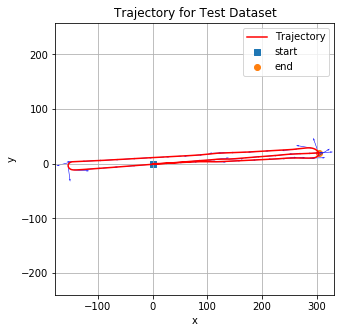

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2341ab9e2e8>)

In [90]:
utils.visualize_trajectory_2d(inv_poses, path_name='Trajectory',plot_title='Trajectory for Test Dataset', show_ori=True)

In [39]:
def image_to_camera_frame(pixel):
    """
    Tranforms pixels from stereo camera pixels to coordinates in the camera frame
    """
    
    z = M[0,0]*b/(pixel[0]-pixel[2])
    x = (pixel[0] - M[0,2])*z/M[0,0]
    y = (pixel[1] - M[1,2])*z/M[1,1]
    
    return np.array([[x], [y], [z], [1]])


In [40]:
def camera_to_world_frame(camera_coord, current_inv_pose):
    """
    Transforms coordinate in camera frame to world frame
    
    current_inv_pose: current pose of imu with respect to the world frame (inverse of what we are keeping track of, iTw)
    """
    
    imu_T_cam = np.linalg.inv(cam_T_imu)
    world_T_imu = current_inv_pose
    
    return np.dot( np.dot(world_T_imu, imu_T_cam), camera_coord)

In [61]:
f = image_to_camera_frame(features[:,0,0])
print(f.shape)
g = camera_to_world_frame(f, inv_poses[:,:,0])
print(g.shape)


(4, 1)
(4, 1)


In [91]:
initial_landmarks = np.ones((4, features.shape[1]))

In [92]:
for i in range(features.shape[2]):
    for j in range(features.shape[1]):
        current_pixel = features[:,j,i]
        if current_pixel[0] == -1:
            continue
        else:
            camera_frame = image_to_camera_frame(current_pixel)
            world_frame = camera_to_world_frame(camera_frame, inv_poses[:,:,i])
            initial_landmarks[:3,j] = world_frame[:3].reshape(3,)
            
            

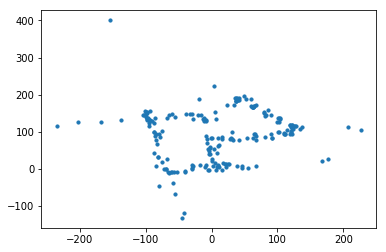

In [64]:
plt.scatter(initial_landmarks[0,:],initial_landmarks[1,:], s = 10)
plt.show()


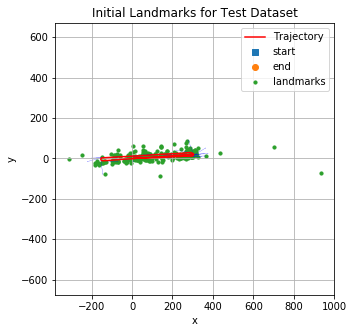

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2341d7dc2e8>)

In [93]:
utils.visualize_trajectory_2d(inv_poses,path_name='Trajectory', plot_title='Initial Landmarks for Test Dataset',
                              show_ori=True, show_landmarks=True, landmarks=initial_landmarks)

In [47]:
def jacobian_of_pi(x, current_pose, D):
    """
    Evaluates the jacobian of pi at x
    
    x: current optical frame coordinate
    """
    
    A = np.array([[1/x[2], 0, -x[0]/x[2]**2, 0],
                     [0, 1/x[2], -x[1]/x[2]**2, 0],
                     [0, 0, 0, 0],
                     [0, 0, -1/x[2]**2, 1/x[2]]])
    
    return np.dot( M, np.dot(A, np.dot(cam_T_imu, np.dot(current_pose, D))))

In [48]:
def update_EKF(current_mean, current_cov, current_pose, actual_pixel):
    """
    Update step for EKF
    
    current_mean: current landmark position in world frame
    current_cov: current covariance of landmark position
    current_pose: current transform from world to imu frame
    actual_pixel: current measured pixel values 
    """
    camera_coord = np.dot( np.dot(cam_T_imu, current_pose), current_mean)
    estimated_pixel = np.dot(M, camera_coord/camera_coord[2])
    
    D = np.zeros((4,3))
    D[:3,:] = np.eye(3)
    
    H = jacobian_of_pi(camera_coord, current_pose, D)
    
    matrix_to_be_inverted = np.dot( np.dot(H, current_cov), H.T)
    # If matrix values are too small, return current mean and cov
    for i in range(matrix_to_be_inverted.shape[0]):
        for j in range(matrix_to_be_inverted.shape[1]):
            if matrix_to_be_inverted[i,j] <= 10**-320:
                return current_mean, current_cov
            
    K = np.linalg.pinv( matrix_to_be_inverted )
    K = np.dot( np.dot( current_cov, H.T), K)
    
    new_mean = current_mean + np.dot( np.dot(D, K), actual_pixel - estimated_pixel)
    
    new_cov = np.eye(3) - np.dot(K,H)
    new_cov = np.dot(new_cov, current_cov)
    
    return new_mean, new_cov    
    
    

In [94]:
final_landmarks = np.zeros((4, features.shape[1]))

for i in range(features.shape[1]):
    
    for j in range(features.shape[2]):
        if features[0,i,j] == -1:
            continue
        else:
            break

    current_mean = image_to_camera_frame(features[:,i,j])
    current_mean = camera_to_world_frame(current_mean, inv_poses[:,:,j])

    current_cov = np.eye(3)

    for k in range(j, features.shape[2]):
        if features[0,i,k] == -1:            # When the landmark is not observed
            continue
        else:
            current_mean, current_cov = update_EKF(current_mean.reshape(4,), current_cov, poses[:,:,j], features[:,i,j])

    final_landmarks[:,i] = current_mean        
                
        
        

In [50]:
#difference in inital vs final landmarks
print(final_landmarks[:,3])
print(initial_landmarks[:,3])

[62.94556914 -4.44400956 10.34557973  1.        ]
[65.94712508 -2.94800006 10.19917626  1.        ]


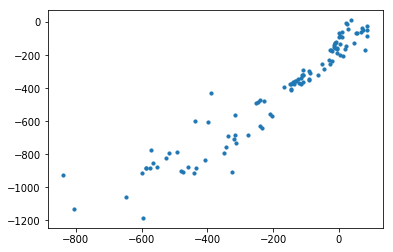

In [334]:
plt.scatter(final_landmarks[0,:],final_landmarks[1,:], s = 10)

plt.show()

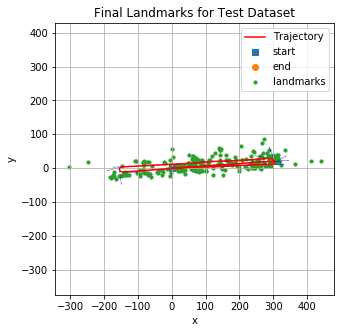

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2341d77f240>)

In [95]:
utils.visualize_trajectory_2d(inv_poses,path_name='Trajectory', plot_title='Final Landmarks for Test Dataset',
                              show_ori=True, show_landmarks=True, landmarks=final_landmarks)